In [ ]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
from matplotlib.gridspec import GridSpec #data viz


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import AdaBoostClassifier

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler


In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
# data = pd.read_csv(r'/content/healthcare-dataset-stroke-data.csv')
# data.head()

In [ ]:
data = pd.read_csv('/content/strokedata.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
data.shape

(5110, 12)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


#Data Cleaning 

In [ ]:
# Defining the related functions

# get Column Names
def col_names(dataframe, cat_th=10, car_th=20):

# cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

# Outliers Threshold
def outlier_threshold(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def outlier_check(dataframe, col_name):
    low_limit, up_limit = outlier_threshold(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False  

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_threshold(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit    
    
# Fill missing values by KNN 
def fill_usingKNN(dataframe,feature):
    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    dataframe1 = pd.get_dummies(dataframe[[feature]], drop_first=True)
    dataframe1 = pd.DataFrame(scaler.fit_transform(dataframe1), columns=dataframe1.columns)
    dataframe1 = pd.DataFrame(imputer.fit_transform(dataframe1), columns=dataframe1.columns)
    dataframe1 = pd.DataFrame(scaler.inverse_transform(dataframe1), columns=dataframe1.columns)
    dataframe[feature] = dataframe1[feature]

In [ ]:
# Checking null records
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
# Filling the bmi null with KNN values
scaler = StandardScaler()
fill_usingKNN(data,"bmi")

In [ ]:
# Checking columns for ourlier Threshold 
cols_to_plot = ['age', 'avg_glucose_level', 'bmi']
for col in cols_to_plot:
    print(col, outlier_check(data, col))

age False
avg_glucose_level False
bmi True


In [ ]:
# Replace with Thresholds
for col in cols_to_plot:
    replace_with_thresholds(data, col)

In [ ]:
# Checking columns for ourlier Threshold 
cols_to_plot = ['age', 'avg_glucose_level', 'bmi']
for col in cols_to_plot:
    print(col, outlier_check(data, col))

age False
avg_glucose_level False
bmi False


In [ ]:
print(f"Summary Of The Dataset :")
data.describe()

Summary Of The Dataset :


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.887479,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.653884,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,80.087500,1.000000


In [ ]:
# Checking duplicate
dup = data[data.duplicated()].shape[0]
print(f"There is {dup} duplicate entry among {data.shape[0]} entries in this dataset.")


There is 0 duplicate entry among 5110 entries in this dataset.


#Exploratory Data Analysis

In [ ]:
df= data.copy()

# Removing stroke = 0 for visualization
df1 = df[df['stroke'] == 1]

In [ ]:
df1.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


<Axes: >

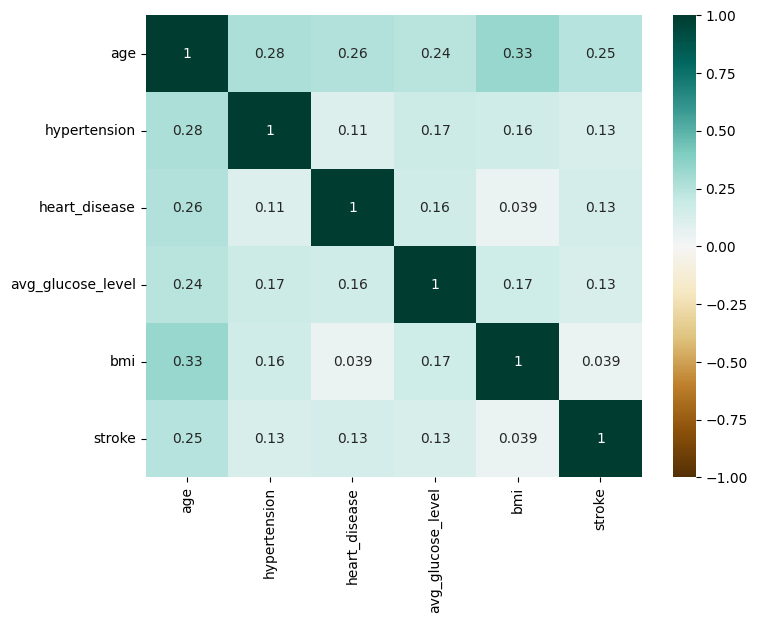

In [ ]:
# Insert correlation coefficients
# Drop column 'id'
data = data.drop('id', axis=1)

plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), vmin = -1.0, vmax = 1.0, cmap="BrBG",
            annot=True)

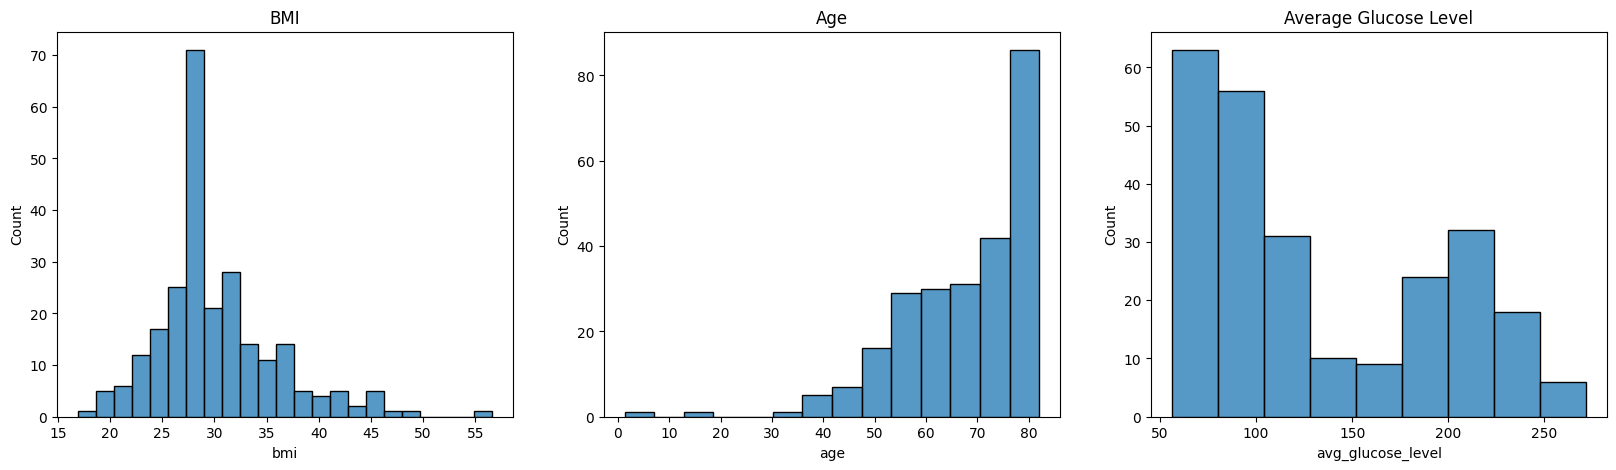

In [ ]:
# Create a figure with multiple subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

# Plot the histograms in different subplots
sns.histplot(x='bmi', data=df1, ax=axs[0])
axs[0].set_title('BMI')

sns.histplot(x='age', data=df1, ax=axs[1])
axs[1].set_title('Age')

sns.histplot(x='avg_glucose_level', data=df1, ax=axs[2])
axs[2].set_title('Average Glucose Level')

# Show the plot
plt.show()

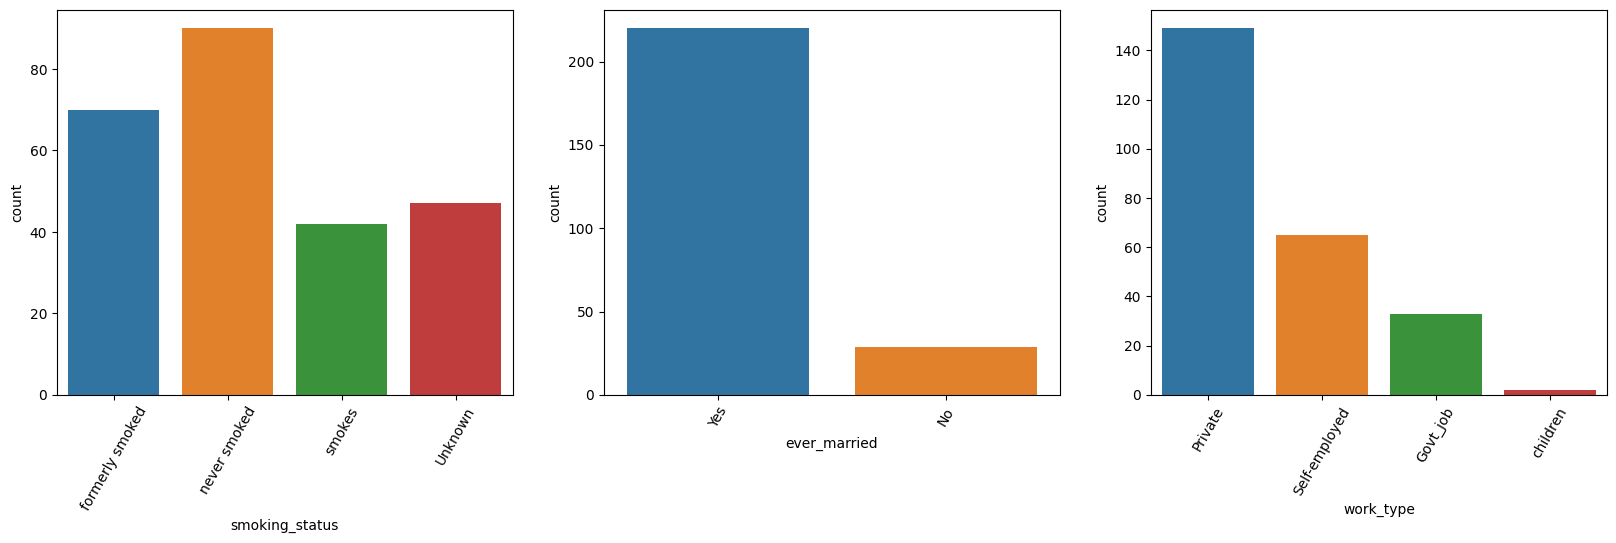

In [ ]:
# Create subplots for each variable
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))

# Plot the countplots
sns.countplot(x="smoking_status", data=df1, ax=axs[0])
sns.countplot(x="ever_married", data=df1, ax=axs[1])
sns.countplot(x="work_type", data=df1, ax=axs[2])

# Rotate x-axis labels by 60 degrees
for ax in axs:
    ax.tick_params(axis='x', labelrotation=60)

# Show the plot
plt.show()


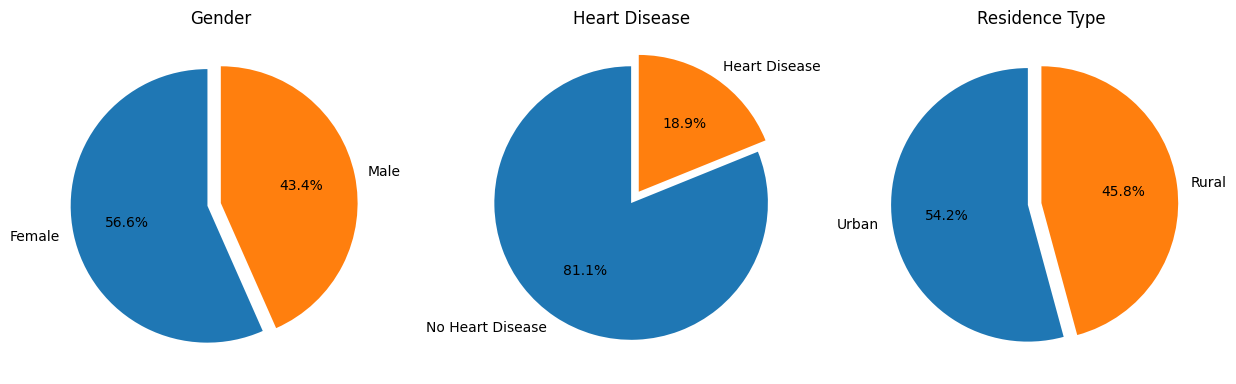

In [ ]:
heart_disease_counts = df1['heart_disease'].value_counts()
residence_type_counts = df1['Residence_type'].value_counts()


# Create a pie chart
labels = ['No Heart Disease', 'Heart Disease']
colors = ['#1f77b4', '#ff7f0e']
explode = [0, 0.1]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Plot the pie chart for the gender column
axs[0].pie(df1['gender'].value_counts(), labels=df1['gender'].value_counts().index, colors=['#1f77b4', '#ff7f0e'], explode=[0.1, 0], autopct='%1.1f%%', startangle=90)
axs[0].set_title('Gender')

# Plot the pie chart for the heart_disease column
axs[1].pie(heart_disease_counts, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Heart Disease')

# Plot the pie chart for the Residence_type column
axs[2].pie(residence_type_counts, labels=residence_type_counts.index, colors=['#1f77b4', '#ff7f0e'], explode=[0.1, 0], autopct='%1.1f%%', startangle=90)
axs[2].set_title('Residence Type')

plt.show()


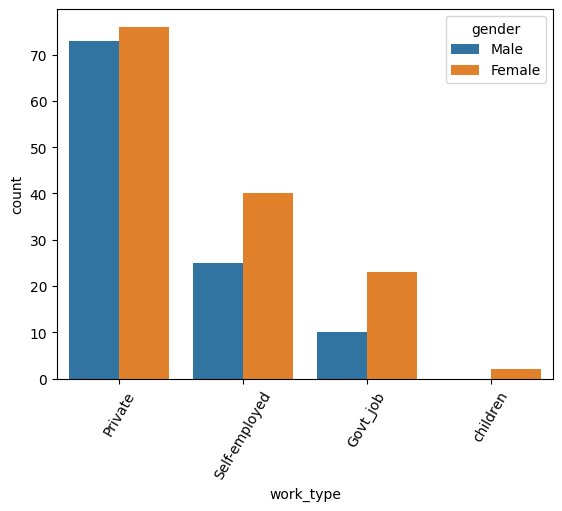

In [ ]:
# Create the countplot by gender
sns.countplot(x="work_type", data=df1, hue="gender")          

# Rotate x-axis labels
plt.xticks(rotation=60)
plt.show()

In [ ]:
# Create a scatter plot with different colors for each gender
sns.scatterplot(x='age', y='stroke', hue='gender', data=df1)

# Set x-axis label
plt.xlabel('Age')

# Set y-axis label
plt.ylabel('Stroke')

# Show the plot
plt.show()


In [ ]:
sns.pairplot(data=df, vars=['age', 'avg_glucose_level', 'bmi'], hue='stroke')
plt.show()

In [ ]:
import plotly.express as px

fig = px.scatter(df, x='age', y='avg_glucose_level', color='stroke',
                 hover_data=['bmi'], title='Age vs. Average Glucose Level')
fig.show()

#Deriving New Features

In [ ]:
df['bmi_cat'] = pd.cut(df['bmi'], bins = [0, 19, 25,30,10000], labels = ['Underweight', 'Ideal', 'Overweight', 'Obesity'])
df['age_cat'] = pd.cut(df['age'], bins = [0,13,18, 45,60,200], labels = ['Children', 'Teens', 'Adults','Mid Adults','Elderly'])
df['glucose_cat'] = pd.cut(df['avg_glucose_level'], bins = [0,90,160,230,500], labels = ['Low', 'Normal', 'High', 'Very High'])

In [ ]:
le = LabelEncoder()

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

In [ ]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [ ]:
for col in binary_cols:
    df = label_encoder(df, col)
    
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df = one_hot_encoder(df, ohe_cols)

In [ ]:
cat_cols, num_cols, cat_but_car = col_names(data)

In [ ]:
df[num_cols] = scaler.fit_transform(df[num_cols])

Encoding and Scaling

In [ ]:
le = LabelEncoder()

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

In [ ]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [ ]:
for col in binary_cols:
    df = label_encoder(df, col)
    
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df = one_hot_encoder(df, ohe_cols)

In [ ]:
df[num_cols] = scaler.fit_transform(df[num_cols])

In [ ]:
df.head()

#Modeling

In [ ]:
y = df["stroke"]
X = df.drop(["stroke","id"], axis=1)

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()
x_smote,y_smote=smote.fit_resample(X,y)

In [ ]:
X_train,X_test, y_train,y_test=train_test_split(x_smote,y_smote,test_size=0.33,random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.35, random_state=42)

In [ ]:
sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#Classification Models

In [ ]:
results = pd.DataFrame(columns = ['KNN', 'SVC', 'LR', 'RF', 'XGB', 'LGBM','AdaBoost'], index = range(5))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=17)

In [ ]:
smote_over_sampling = SMOTE(random_state=1)
x_train_resampled, y_train_resampled = smote_over_sampling.fit_resample(X_train, y_train)

#### KNN

In [ ]:

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train_resampled, y_train_resampled)
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 1] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 1] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 1] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 1] = round(roc_auc_score(y_test, y_prob), 3)
knn_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(knn, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(knn, x_train_resampled, y_train_resampled, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(knn, x_train_resampled, y_train_resampled, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(knn, x_train_resampled, y_train_resampled, cv = 5, scoring = 'f1').mean(), 2)}")

results.iloc[4, 1] = round(cross_val_score(knn, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(knn_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
from sklearn import metrics

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

####SVC

In [ ]:
svc = SVC(random_state = 22, probability = True)
svc.fit(x_train_resampled, y_train_resampled)
y_pred = svc.predict(X_test)
y_prob = svc.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 0] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 0] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 0] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 0] = round(roc_auc_score(y_test, y_prob), 3)
svc_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(svc, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(svc, x_train_resampled, y_train_resampled, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(svc, x_train_resampled, y_train_resampled, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(svc, x_train_resampled, y_train_resampled, cv = 5, scoring = 'f1').mean(), 2)}")


results.iloc[4, 0] = round(cross_val_score(svc, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)


# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(svc_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
from sklearn import metrics

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

####Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(random_state = 42, max_depth = 5)
rf.fit(x_train_resampled, y_train_resampled)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 3] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 3] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 3] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 3] = round(roc_auc_score(y_test, y_prob), 3)
rf_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(rf, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(rf, x_train_resampled, y_train_resampled, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(rf, x_train_resampled, y_train_resampled, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(rf, x_train_resampled, y_train_resampled, cv = 5, scoring = 'f1').mean(), 2)}")

results.iloc[4, 3] = round(cross_val_score(rf, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)


# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(rf_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
from sklearn import metrics
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp2 = pd.DataFrame(columns = ['feature', 'importance'], index = range(26))
for i in range(len(f_imp2.index)):
    f_imp2.iloc[i, 0] = x_train_resampled.columns.to_list()[i]
f_imp2['importance'] = rf.feature_importances_
f_imp2 = f_imp2.sort_values('importance', ascending = False)
f_imp2[0:12].style.background_gradient(cmap = 'Blues')

####Logistic Regression

In [ ]:
lg = LogisticRegression(random_state = 42)
lg.fit(x_train_resampled, y_train_resampled)
y_pred = lg.predict(X_test)
y_prob = lg.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 2] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 2] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 2] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 2] = round(roc_auc_score(y_test, y_prob), 3)
lg_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(lg, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(lg, x_train_resampled, y_train_resampled, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(lg, x_train_resampled, y_train_resampled, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(lg, x_train_resampled, y_train_resampled, cv = 5, scoring = 'f1').mean(), 2)}")

results.iloc[4, 2] = round(cross_val_score(lg, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)



# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(lg_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
from sklearn import metrics

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp = pd.DataFrame(columns = ['feature', 'importance (abs coef)'], index = range(26))
for i in range(len(f_imp.index)):
    f_imp.iloc[i, 0] = x_train_resampled.columns.to_list()[i]
f_imp['importance (abs coef)'] = abs(lg.coef_)[0]
f_imp = f_imp.sort_values('importance (abs coef)', ascending = False)
f_imp[0:12].style.background_gradient(cmap = 'Blues')

####XGBoost

In [ ]:
xgb = XGBClassifier(random_state = 42, max_depth = 5, objective = 'binary:logistic', eval_metric = 'logloss')
xgb.fit(x_train_resampled, y_train_resampled)
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 4] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 4] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 4] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 4] = round(roc_auc_score(y_test, y_prob), 3)
xgb_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(xgb, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(xgb, x_train_resampled, y_train_resampled, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(xgb, x_train_resampled, y_train_resampled, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(xgb, x_train_resampled, y_train_resampled, cv = 5, scoring = 'f1').mean(), 2)}")

results.iloc[4, 4] = round(cross_val_score(xgb, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(xgb_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
from sklearn import metrics

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp3 = pd.DataFrame(columns = ['feature', 'importance'], index = range(26))
for i in range(len(f_imp3.index)):
    f_imp3.iloc[i, 0] = x_train_resampled.columns.to_list()[i]
f_imp3['importance'] = xgb.feature_importances_
f_imp3 = f_imp3.sort_values('importance', ascending = False)
f_imp3[0:12].style.background_gradient(cmap = 'Blues')

####LightGBM

In [ ]:
lgbm = LGBMClassifier(random_state = 42, max_depth = 5, num_leaves = 50)
lgbm.fit(x_train_resampled, y_train_resampled)
y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 5] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 5] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 5] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 5] = round(roc_auc_score(y_test, y_prob), 3)
lgbm_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(lgbm, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(lgbm, x_train_resampled, y_train_resampled, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(lgbm, x_train_resampled, y_train_resampled, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(lgbm, x_train_resampled, y_train_resampled, cv = 5, scoring = 'f1').mean(), 2)}")

results.iloc[4, 5] = round(cross_val_score(lgbm, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)


# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(lgbm_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
from sklearn import metrics

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp4 = pd.DataFrame(columns = ['feature', 'importance'], index = range(26))
for i in range(len(f_imp4.index)):
    f_imp4.iloc[i, 0] = x_train_resampled.columns.to_list()[i]
f_imp4['importance'] = lgbm.feature_importances_
f_imp4 = f_imp4.sort_values('importance', ascending = False)
f_imp4[0:12].style.background_gradient(cmap = 'Blues')

####AdaBoost Classifier(AdaptiveBoosting)

In [ ]:
Ada = AdaBoostClassifier(n_estimators=2000, random_state = 42)
Ada.fit(x_train_resampled, y_train_resampled)
y_pred = Ada.predict(X_test)
y_prob = Ada.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 6] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 6] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 6] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 6] = round(roc_auc_score(y_test, y_prob), 3)
Ada_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(Ada, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(Ada, x_train_resampled, y_train_resampled, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(Ada, x_train_resampled, y_train_resampled, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(Ada, x_train_resampled, y_train_resampled, cv = 5, scoring = 'f1').mean(), 2)}")

results.iloc[4, 6] = round(cross_val_score(Ada, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(Ada_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
from sklearn import metrics

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature importance
f_imp4 = pd.DataFrame(columns = ['feature', 'importance'], index = range(26))
for i in range(len(f_imp4.index)):
    f_imp4.iloc[i, 0] = x_train_resampled.columns.to_list()[i]
f_imp4['importance'] = Ada.feature_importances_
f_imp4 = f_imp4.sort_values('importance', ascending = False)
f_imp4[0:12].style.background_gradient(cmap = 'Blues')



## comparing the outcome



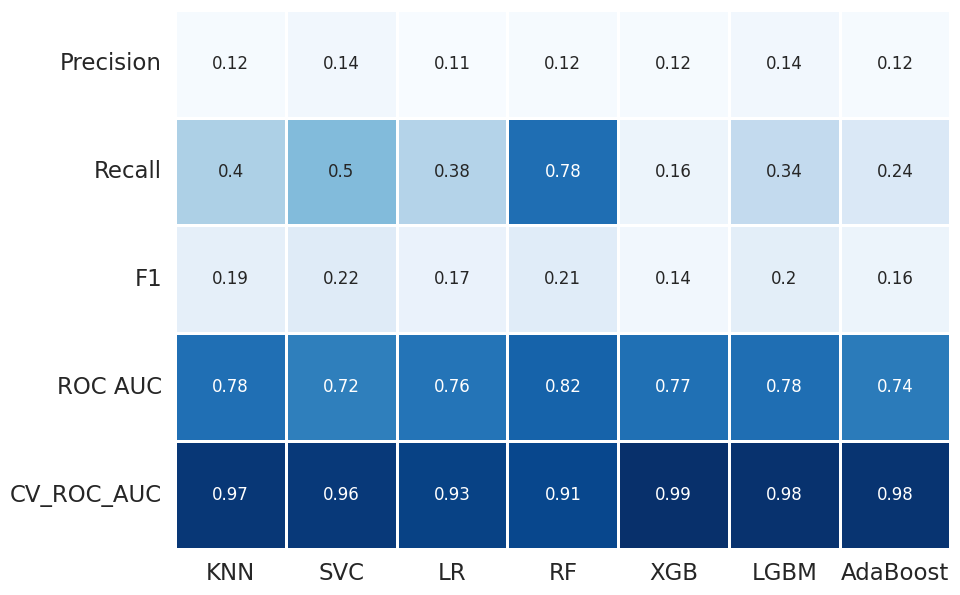

In [82]:
plt.figure(figsize = (10, 7))
sns.heatmap(results[results.columns.to_list()].astype(float), cmap = 'Blues', annot = True, linewidths = 1, cbar = False, annot_kws = {'fontsize': 12},
           yticklabels = ['Precision', 'Recall', 'F1', 'ROC AUC','CV_ROC_AUC'])
sns.set(font_scale = 1.5)
plt.yticks(rotation = 0)
plt.show()



## Explainable AI



Choosing an explainable AI technique to interpret the model's predictions and understand the factors influencing stroke prediction. We are using SHAP (SHapley Additive exPlanations), which provides global and local interpretability.
Using SHAP values to identify the contribution of each feature towards the prediction for individual instances and visualize the results.

Prioritize metrics such as recall, precision, and F1-score for XAI in stroke prediction. These metrics focus on the model's ability to correctly identify stroke cases and minimize false negatives while understanding the feature contributions through SHAP values.
We see that recall is very high for RF.

In [ ]:
pip install shap

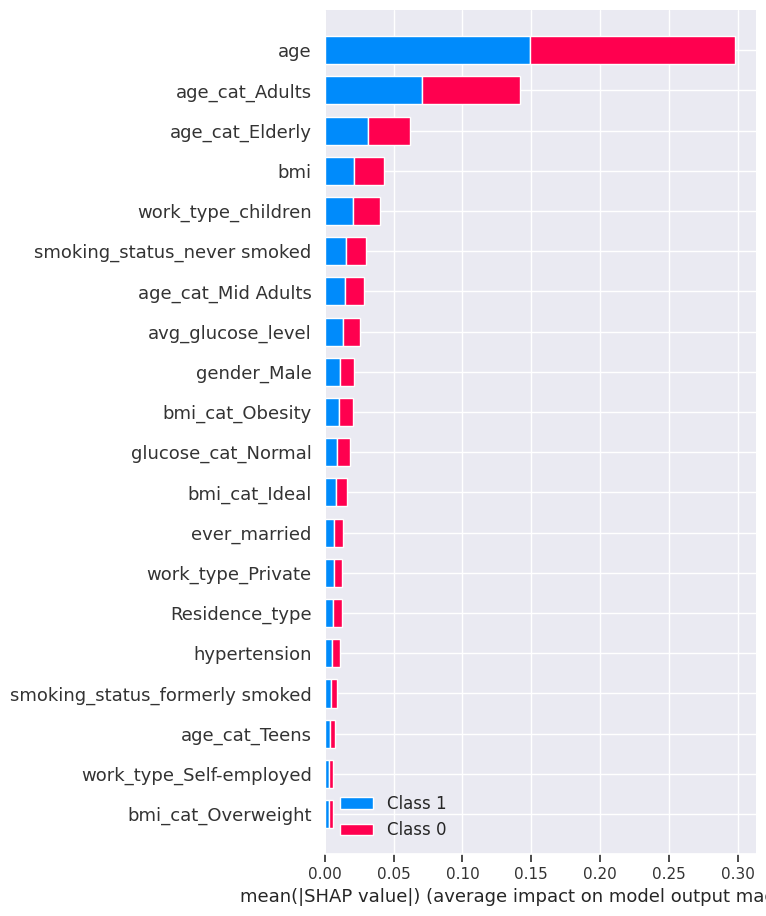

In [83]:
import shap
# Initialize the explainer with the trained model and the X_train dataset
explainer = shap.Explainer(rf, x_train_resampled)
shap_values = explainer.shap_values(X_test[:100])

# Plot feature importance using bar plots
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [84]:
print(shap_values[0].shape)
print(shap_values[1].shape)
print(X_test.shape)

(100, 26)
(100, 26)
(1022, 26)


In [85]:
X_test_subset = X_test[:shap_values[0].shape[0]]

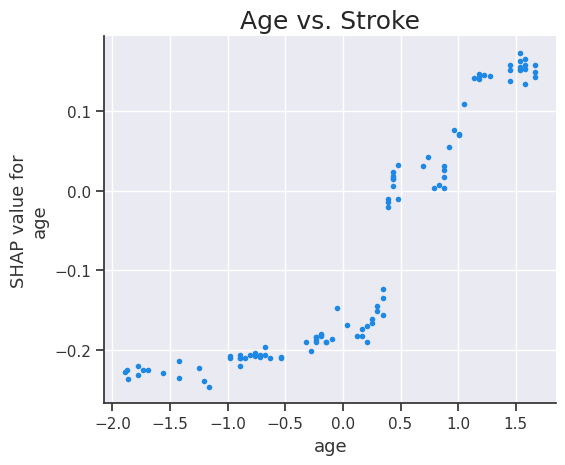

In [86]:
# Individual Feature Plot for age

shap.dependence_plot('age', shap_values[1], X_test_subset, interaction_index=None, show=False)
plt.title('Age vs. Stroke')
plt.tight_layout()
plt.show()

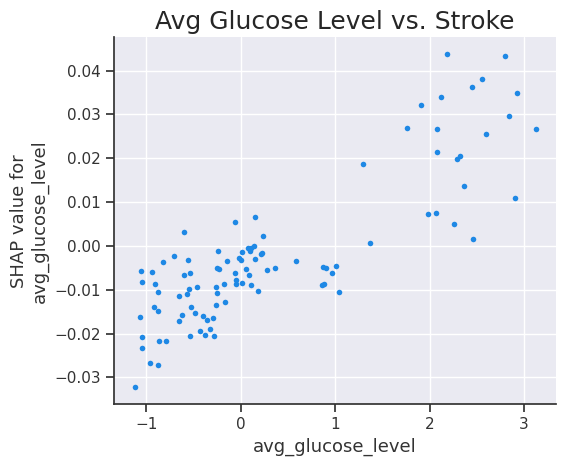

In [87]:
shap.dependence_plot('avg_glucose_level', shap_values[1], X_test_subset, interaction_index=None, show=False)
plt.title('Avg Glucose Level vs. Stroke')
plt.tight_layout()
plt.show()

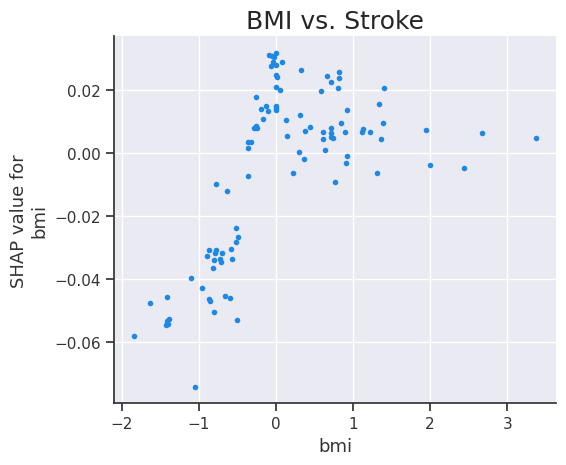

In [88]:
shap.dependence_plot('bmi', shap_values[1], X_test_subset, interaction_index=None, show=False)
plt.title('BMI vs. Stroke')
plt.tight_layout()
plt.show()

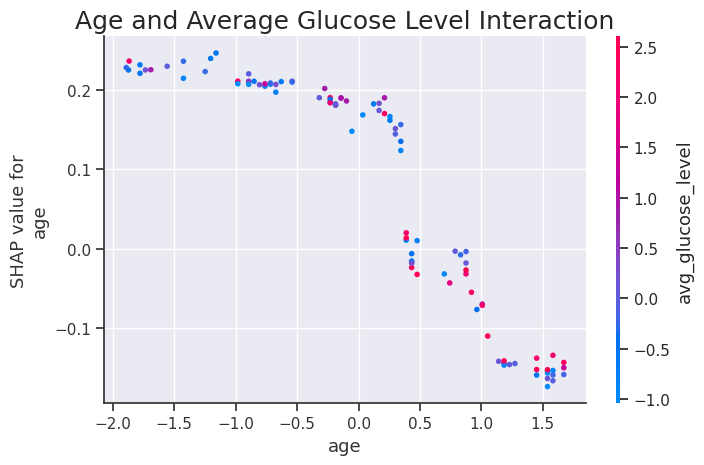

In [89]:
shap.dependence_plot('age', shap_values[0], X_test_subset, interaction_index='avg_glucose_level', show=False)
plt.title('Age and Average Glucose Level Interaction')
plt.tight_layout()
plt.show()

In [ ]:
redict